In [141]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
import Pkg; Pkg.add("TrajectoryOptimization")
import Pkg; Pkg.add("Plots")
using TrajectoryOptimization
import TrajectoryOptimization: get_times
using RobotDynamics
import RobotZoo.Acrobot
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using OSQP
using Plots
using TrajOptPlots
using Colors
using Printf
using Test
using JLD2
include("acrobot.jl")
include("utils.jl")
const resfile = joinpath(@__DIR__,"q3.jld2")
const isautograder = @isdefined autograder;

  Activating environment at `~/Desktop/OptimalC/Homeworks/homework4-afariach/Project.toml`


   Resolving package versions...


  No Changes to `~/Desktop/OptimalC/Homeworks/homework4-afariach/Project.toml`
  No Changes to `~/Desktop/OptimalC/Homeworks/homework4-afariach/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Desktop/OptimalC/Homeworks/homework4-afariach/Project.toml`
  No Changes to `~/Desktop/OptimalC/Homeworks/homework4-afariach/Manifest.toml`


# Question 3: Iterative Learning Control (25 pts)
In this problem we'll be exploring the use of iterative learning control (ILC) to update our trajectories to work on a "real" system with some un-modeled system dynamics. We'll first find an optimalized trajectory using our approximate model, and then refine those trajectories using ILC to achieve the desired behavior. 

## Dynamics
We'll keep things simple by applying this to the "acrobot" system, which is just a double pendulum with actuation only at the elbow joint. We'll use the model out of RobotZoo.

## Setting up the Optimization problem
We'll use TrajectoryOptimization.jl to define our problem. We specify an initial and terminal constraint, a quadratic cost function that penalizes distance from the goal, and bounds on the torques. 

In [142]:
# Dynamics Model
l0 = @SVector [1.0, 1.0]
m0 = @SVector [1.0, 1.0]
J0 = @SVector [(1.0/12)*m0[1]*l0[1]*l0[1], (1.0/12)*m0[2]*l0[2]*l0[2]]
model = Acrobot(l0, m0, J0)
n,m = size(model);

# Discretization
N = 101
Tf = 5.
h = Tf/(N-1)

# Initial and Final Conditions
x0 = @SVector [-pi/2, 0, 0, 0]
xf = @SVector [pi/2, 0, 0, 0];  # i.e. swing up

# Objective
Q = 100.0*Diagonal(@SVector ones(n))
Qf = 1000.0*Diagonal(@SVector ones(n))
R = 1.0*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

# Constraints
conSet = ConstraintList(n,m,N)

# Control bounds
u_bnd = 20.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

# Goal constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

# Define the problem
prob = Problem(model, obj, xf, Tf, x0=x0, constraints=conSet, integration=RK4);

# Initial controls
U0 = [randn() for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

## Solving the Problem
We'll make it easy for you and and solve the problem using ALTRO. Run the code below to solve for the optimized trajectory and visualize the result.

In [143]:
using Altro
using Random
opts = SolverOptions(
    iterations=1000,
    constraint_tolerance=1e-4,
    projected_newton=0,
    verbose=0
)

Random.seed!(1)
U0 = [randn() for k = 1:N-1]
initial_controls!(prob, U0)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 877
    Solve Time: 337.43490199999997 (ms)

  Covergence
    Terminal Cost: 5607.5892866843205
    Terminal dJ: 1.4423168067878578e-5
    Terminal gradient: 0.009015517830683833
    Terminal constraint violation: 3.501533653182953e-5
    Solve Status: SOLVE_SUCCEEDED


In [144]:
if !isautograder
    vis = Visualizer()
    TrajOptPlots.set_mesh!(vis, model)
    render(vis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8706
└ @ MeshCat /Users/Augusto/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8706))

In [145]:
isautograder || visualize!(vis, model, Tf, states(altro))

## Part (a): Simulate on "Real" System (6 pts)
Using out optimized trajectory, design a TVLQR control policy to tracking the new system. You'll also implement a basic simulator to test out your controller on the "real" system, which is slightly different than our nominal model. 

In [146]:
#Dynamics 
function dynamics_jacobian(model, x, u, t, dt)
    z = KnotPoint(x, u, dt, t)
    ∇f = RobotDynamics.DynamicsJacobian(model)
    RobotDynamics.discrete_jacobian!(RK4, ∇f, model, z)
    return ∇f.A, ∇f.B
end

dynamics_jacobian (generic function with 1 method)

In [147]:
# TASK: Calculate the TVLQR gains (3 pts)

# Extract reference trajectory
Xref = states(altro)
Uref = controls(altro)
times = get_times(altro)

# TODO: Calculate the TVLQR gains and the linearized dynamics about the reference trajectory
n,m,N = size(altro)
A = [zeros(n,n) for k = 1:N-1]
B = [zeros(n,m) for k = 1:N-1]
K = [zeros(m,n) for k = 1:N-1]
Plqr = [zeros(n,n) for i = 1:N]
Plqr[end] .= Qf
for k = 1:N-1
    A[k],B[k] = dynamics_jacobian(prob.model,Xref[k],Uref[k],times[k],h);
end 
for k = reverse(1:N-1) 
    K[k] .= (R + B[k]'Plqr[k+1]*B[k])\(B[k]'Plqr[k+1]*A[k])
    Plqr[k] .= Q + A[k]'Plqr[k+1]*A[k] - A[k]'Plqr[k+1]*B[k]*K[k]
end


In [148]:
@testset "Q3a: TVLQR" begin                                     # POINTS = 3
    @test A ≈ load(resfile, "A") rtol=1e-3                      # POINTS = 1
    @test B ≈ load(resfile, "B") rtol=1e-3                      # POINTS = 1
    @test K ≈ load(resfile, "K") rtol=1e-3                      # POINTS = 1
end;

Test Summary: | Pass  Total
Q3a: TVLQR    |    3      3


In [149]:
# TASK: Implement the following function (3 pts)
"""
    rollout(model, K, Xref, Uref, times; [u_bnd, x0])

Simulate the system with the TVLQR controller specified by the feedback gains `K` and reference trajectory `Xref`, `Uref`, and `times`.

Should clamp the controls to be between `-u_bnd` and `+u_bnd` prior to integrating the system dynamics.

For the dynamics integration, use `x′ = true_dynamics_rk4(model, x, u, dt)`.
"""
function rollout(model::Acrobot, K, Xref, Uref, times; u_bnd=20.0, x0=Xref[1])
    n,m = size(model)
    N = length(K) + 1
    X = [@SVector zeros(n) for k = 1:N]
    U = [@SVector zeros(m) for k = 1:N-1]
    X[1] = x0
    for k = 1:N-1
        U[k] = clamp.(Uref[k] -K[k]*(X[k]-Xref[k]),-u_bnd,u_bnd)
        X[k+1] = true_dynamics_rk4(model,X[k],U[k],times[k+1]-times[k])
    end 
    
    # TODO: Simulate at the same time step as the reference trajectory
    #  TIP: just loop over the indices, instead of time (just to make it easier)
    #  TIP: remember to use `true_dynamics_rk4(model, x, u, dt)` to simulate your dynamics!
    #  TIP: remember to clamp your controls before sending them to them to the simulator!
    
    return X, U
end
Xsim,Usim = rollout(model, K, states(altro), controls(altro), get_times(altro));

In [150]:
@testset "Q3a: rollout" begin                                  # POINTS = 3
    @test norm(Xsim[1] - states(altro)[1]) < 1e-8              # POINTS = 1
    @test 1 < norm(Xsim[end] - states(altro)[end]) < 2         # POINTS = 1
    @test abs(maximum(norm.(Usim,Inf)) - u_bnd) < 1e-8         # POINTS = 1
end;

Test Summary: | Pass  Total
Q3a: rollout  |    3      3


In [151]:
isautograder || render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8706))

In [152]:
# visualize with ghost of the reference trajectory
isautograder || visualize!(vis, model, Tf, Xsim, states(altro), colors=[colorant"blue", RGBA(0,0,1,0.5)])

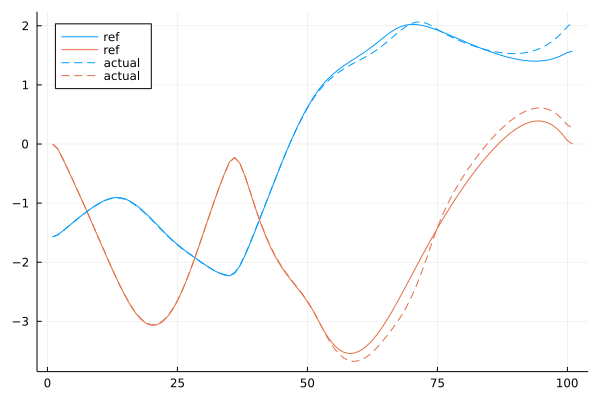

In [153]:
# compare the joint angles
isautograder || plot(states(altro), inds=1:2, label="ref")
isautograder || plot!(Xsim, inds=1:2, color=[1 2], ls=:dash, legend=:topleft, label="actual")

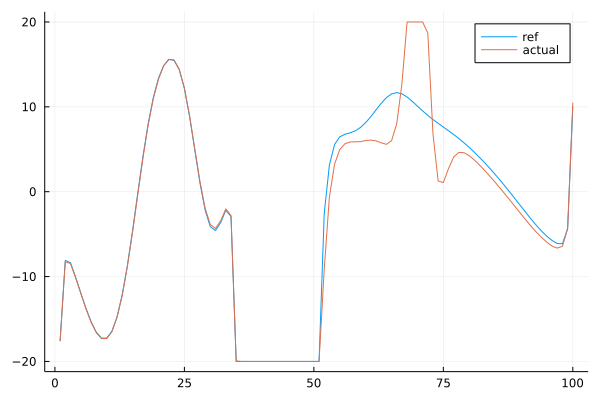

In [154]:
# compare the controls
isautograder || plot(controls(altro), label="ref")
isautograder || plot!(Usim, label="actual")

## Part (b): Setting up the ILC QP (9 pts)
With a reference trajectory and closed-loop controller, let's use ILC to modify the feedforward (reference) control inputs to get our "real" system to match our expected trajectory. At each iteration of ILC you should solve a QP of the following form:

$$
\begin{align}
\text{minimize} &&& \frac{1}{2} (\Delta x_N - \Delta \bar{x}_N)^T Q_N (\Delta x_N - \Delta \bar{x}_N) 
+ \frac{1}{2} \sum_{k=1}^{N-1} (\Delta x_k - \Delta \bar{x}_k)^T Q_k (\Delta x_k - \Delta \bar{x}_k)
                             + (\Delta u_k - \Delta \bar{u}_k)^T R_k (\Delta u_k - \Delta \bar{u}_k) \\
\text{subject to} &&& \Delta x_{k+1} = A_k \Delta x_k + B_k \Delta x_k \\
                  &&& -\Delta u_\text{bnd} \leq \Delta u_k \leq \Delta u_\text{bnd}
\end{align}
$$
where $\Delta x = x - x_\text{ref}$, $\bar{x}_k$ is the trajectory from the real system, and $x_\text{ref}$, $u_\text{ref}$ is the reference trajectory. After every iteration, the reference controls $u_\text{ref}$ are updated using $\Delta u$. The linearized dynamics are the dynamics of the **closed-loop** system.

In [155]:
# TASK: Complete the following function
#       1. build_qp    (5 pts)
#       2. update_qp!  (4 pts)

"""
    ILCData

Store basic information about the iterative learning control (ILC)
problem, including the quadratic cost function matrices, the reference
trajectory, and the control bounds.
"""
struct ILCData{n,m,T}
    Q::Diagonal{T,SVector{n,T}}
    R::Diagonal{T,SVector{m,T}}
    Qf::Diagonal{T,SVector{n,T}}
    Xref::Vector{SVector{n,T}}
    Uref::Vector{SVector{m,T}}
    times::Vector{T}
    u_bnd::T
    iters::Ref{Int}
end

"""
    build_qp(data, Xsim, Usim, A,B,K)

Build the QP for the ILC problem, using the data for the ILC problem in `data`,
the trajectories from the real system `Xsim`, `Usim`, the linearization about
the reference trajectory `A`, `B`, and the feedback matrices `K`.

TIP: The dynamics constraints should be on the closed-loop system.
"""
function build_qp(data::ILCData, Xsim, Usim, A,B,K)
    Nh = length(data.Xref)
    n,m = size(B[1])
    Xref,Uref = data.Xref, data.Uref
    
    # TODO: Build the QP for ILC
    Np = (Nh-1)*(n+m)         # number of primals
    Nd = (Nh-1)*n + (Nh-1)*m  #  number of duals
    H = spzeros(Np,Np)
    q = zeros(Np)
    C = spzeros(Nd,Np)
    lb = fill(-Inf,Nd)
    ub = fill(+Inf,Nd)
    #Build matrices for ILC QP

    #Cost
    H = blockdiag(kron(I(Nh-2), blockdiag(sparse(data.R), sparse(data.Q))), sparse(data.R), sparse(data.Qf))

    q = zeros((n+m)*(Nh-1))

    for k = 1:(Nh-2)
        q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; data.Q*(Xsim[k+1]-data.Xref[k+1])]
    end
    
    q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; data.Qf*(Xsim[Nh]-data.Xref[Nh])]

    # C = spzeros((Nh-1)*n + (Nh-1)*m, (n+m)*(Nh-1)) #dynamics constraints
    U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
    C[1:n,1:m] .= B[1]
    C[1:n,(m+1):(m+n)] .= -I(n)
    for k = 1:(Nh-2)
        C[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[k+1]-B[k+1]*K[k+1] B[k+1] -I]
    end 

    neg_Δu = zeros(length(data.Uref))
    pos_Δu = zeros(length(data.Uref))

    for k= 1:(Nh-1)
       neg_Δu[k] = -data.u_bnd - data.Uref[k][1]
       pos_Δu[k] = data.u_bnd - data.Uref[k][1]
    end


    lb = [zeros(n*(Nh-1)); neg_Δu]
    ub = [zeros(n*(Nh-1)); pos_Δu]

    # Build QP
    qp = OSQP.Model()
    OSQP.setup!(
        qp, P=H, q=q, A=C, l=lb, u=ub,
        # QP Parameters: feel free to change these, but these values should work fine
        eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1, verbose=0
    )
    # @show size(H)
    # @show size(q)
    # @show size([C;L)
    # @show size(lb)
    # @show size(ub)
    return qp
end

"""
    update_qp!(qp, data, X, U)

Update the ILC QP with the current trajectories `X` and `U` from the real system.
"""
function update_qp!(qp::OSQP.Model, data, X, U)
    Nh = length(data.Xref)
    n,m = length(X[1]), length(U[1])
    Qilc, Rilc, Qf = data.Q, data.R, data.Qf
    
    # TODO: Update the QP with the new data
    Np = (Nh-1)*(n+m)
    q = zeros(Np)

    for k = 1:(Nh-2)
        q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(X[k+1]-data.Xref[k+1])]
    end
    q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(X[Nh]-data.Xref[Nh])]

    OSQP.update_q!(qp, q)
    data.iters[] += 1     # Don't change this line!
    return q
end

update_qp!

In [156]:
@testset "Q3b" begin                                                                        # POINTS = 9
    n,m,N = size(altro)
    Xref = states(altro)
    Uref = controls(altro);
    
    # Get simulated trajectory
    Xsim,Usim = rollout(model, K, Xref, Uref, get_times(altro));
    
    # Save data into ILCData
    Qilc = Diagonal(SA[1.0; 1.0; 1.0; 1.0])
    Rilc = Diagonal(SA[0.1])
    Qf = get_objective(altro).obj[end].Q
    u_bnd = get_constraints(altro).convals[1].con.z_max[end]
    data = ILCData(Qilc,Rilc,Qf, Xref, Uref, get_times(altro), u_bnd, Ref(0));
    
    # Build the QP
    qp0 = build_qp(data, Xsim, Usim, A,B,K);
    
    # Solve the QP
    res = OSQP.solve!(qp0)
    @test res.info.status == :Solved                                                      # POINTS = 1
    @test res.x ≈ load(resfile, "resx") rtol=1e-3                                         # POITNS = 4
    
    # Update the QP
    for k in eachindex(Uref)
        Uref[k] += fill(0.1, m)  # this should come from the controller in your implementation!
    end
    data.Uref .= Uref
    Xsim2,Usim2 = rollout(model, K, Xref, Uref, get_times(altro));  # new simulated trajectories
    update_qp!(qp0, data, Xsim2, Usim2)
    res2 = OSQP.solve!(qp0)
    @test res2.info.status == :Solved                                                     # POINTS = 1
    @test norm(res2.x - res.x) > 5                                                        # POINTS = 1
    @test res2.x ≈ load(resfile, "res2x") rtol=1e-3                                       # POINTS = 1
end;

TestSetException: Some tests did not pass: 3 passed, 2 failed, 0 errored, 0 broken.

## Part (c): Implement ILC (10 points)
Using everything we've implemented so far, implement the complete ILC algorithm and validate that the updated 
reference trajectory stabilizes the "true" dynamics.

In [157]:
# TASK: Implement ILC  (10 pts)
"""
    run_ilc(altro; [verbose])

Run ILC on the output on the problem and optimized trajectory stored in `altro`. 
Should iterate until improvements in the SSE between the state trajectory of the real 
system and the nominal trajectory is small (less than `tol`).
"""
function run_ilc(altro;
        verbose=true,
        tol=1e-2)
    
    
    # Get nominal trajectory
    Xref = states(altro)
    Uref = controls(altro);
    times = get_times(altro);
    n,m,Nh = size(altro)
    
    # Get costs out of solver
    Q = get_objective(altro).obj[1].Q
    R = get_objective(altro).obj[1].R
    Qf = get_objective(altro).obj[end].Q
    
    # Get bound out of solver
    u_bnd = get_constraints(altro).convals[1].con.z_max[end]
    
    # ILC Cost functions    
    Qilc = Diagonal(SA[1.0; 1.0; 1.0; 1.0])
    Rilc = Diagonal(SA[0.1])
    
    # Generate ILC Data
    data = ILCData(Qilc,Rilc,Qf, Xref, Uref, get_times(altro), u_bnd, Ref(0));
    
    # # TODO: Use ILC to improve the tracking performance
    # #  TIP: you'll need to generate A,B,K and using the code from part (a)
    # #  TIP: compute the first SSE value outside the loop, and compare between subsequent iterations
    # #  TIP: you should only need to call build_qp once

    A = [zeros(n,n) for k = 1:Nh-1]
    B = [zeros(n,m) for k = 1:Nh-1]
    K = [zeros(m,n) for k = 1:Nh-1]

    Plqr = [zeros(n,n) for i = 1:Nh]
    Plqr[end] .= Qf

    for k = 1:Nh-1
        A[k],B[k] = dynamics_jacobian(prob.model,data.Xref[k],data.Uref[k],times[k],h);
    end 

    for k = reverse(1:Nh-1) 
        K[k] .= (R + B[k]'Plqr[k+1]*B[k])\(B[k]'Plqr[k+1]*A[k])
        Plqr[k] .= Q + A[k]'Plqr[k+1]*A[k] - A[k]'Plqr[k+1]*B[k]*K[k]
    end

    Xsim,Usim = rollout(model, K, data.Xref, data.Uref, get_times(altro));

    sse_hist = [norm(Xsim-data.Xref)]

    qp0 = build_qp(data, Xsim, Usim, A,B,K);
    iters = 100
    
    for i = 1:iters 
        # Solve the QP
        res = OSQP.solve!(qp0)
        # Update the QP
        for k=1:Nh-1
            # @show (n+m)*k
            Uref[k] = Uref[k] .+ res.x[1+(n+m)*(k-1)] # this should come from the controller in your implementation!
        end

        data.Uref .= Uref
        
        #Do rollout with new Uref
        Xsim,Usim = rollout(model, K, data.Xref, data.Uref, get_times(altro));  # new simulated trajectories

        update_qp!(qp0, data, Xsim, Usim)

        # @show size(sse_hist)
        if i != 1
            if norm(sse_hist[i]-sse_hist[i-1]) < tol 
                return Xsim,Usim,data
            end
        end
        sse_hist = [sse_hist norm(Xsim-data.Xref)]
    end 

    
    return Xsim,Usim,data
end

Q3b: Test Failed at /Users/Augusto/Desktop/OptimalC/Homeworks/homework4-afariach/src/Q3.ipynb:22
  Expression: ≈(res.x, load(resfile, "resx"), rtol = 0.001)
   Evaluated: [-0.03230300439271699, 6.107810542092255e-5, -0.0001520490672456188, 0.0023106947932019207, -0.005768159277103182, -0.010037741208757882, 0.0001379709272753223, -0.00034676631266506634, 0.0008042467193017013, -0.0021162005167644593  …  -0.6521357380357706, -0.40337797742727916, -0.23493968621542166, -0.9169703984416917, -0.4797590584614645, 1.457152817926386, -0.4561285908700737, -0.25006929143967443, -1.1803446205053443, -0.1623709603557637] ≈ [-0.025997636225798933, 4.91559963494521e-5, -0.00012236992852806378, 0.0018596599230290612, -0.004642246422515007, -0.0033915023617496, 0.00010251468763387127, -0.00025779390668609104, 0.0003302371852671357, -0.0009079843702899462  …  -0.9515294874517239, -0.39747083138728173, -0.22675448179200489, -0.8757435275858273, -0.5413593993904705, 1.463834846789036, -0.448809318503167

run_ilc

In [158]:
Xilc,Uilc,data = run_ilc(altro)
data.iters[]

14

In [159]:
@testset "Part c" begin                        # POINTS = 10
    @test norm(Xilc - Xref) < 2.1              # POINTS = 2
    @test 10 < norm(Uilc - Uref) < 20          # POINTS = 0.5
    @test norm(Xilc[end] - Xref[end]) < 0.05   # POINTS = 4
    @test data.iters[] < 20                    # POINTS = 2
    @test norm(data.Uref - Uref) > 10          # POINTS = 1
    @test norm(data.Xref - Xref) < 1e-10       # POINTS = 0.5
end;

Test Summary: | Pass  Total
Part c        |    6      6


In [160]:
isautograder || render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot_copies" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot2" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), "robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8706))

In [161]:
# visualize the result (reference shown as a ghost)
# TIP: solutions will differ slightly, but should both reach the goal position
isautograder || visualize!(vis, model, Tf, Xilc, states(altro), colors=[colorant"blue", RGBA(0,0,1,0.5)])

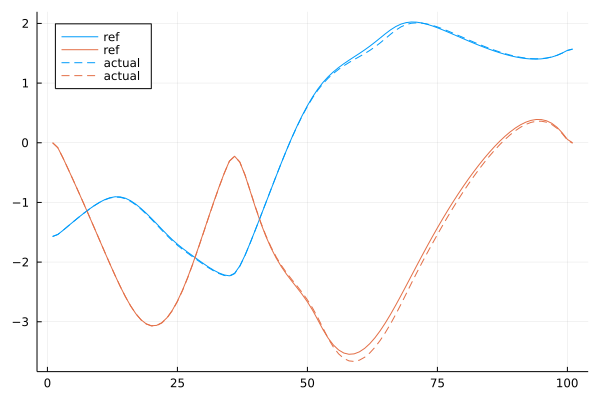

In [162]:
# compare the joint angles
isautograder || plot(states(altro), inds=1:2, label="ref")
isautograder || plot!(Xilc, inds=1:2, color=[1 2], ls=:dash, legend=:topleft, label="actual")

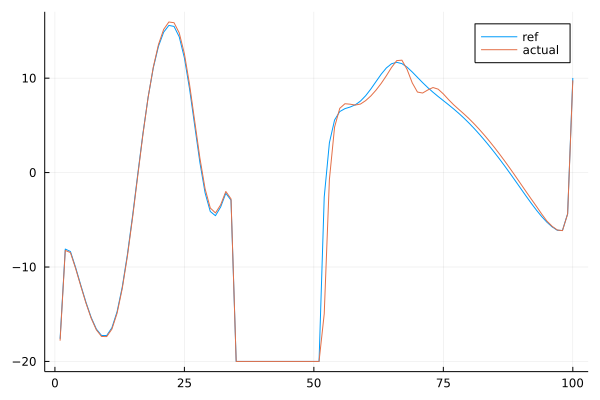

In [163]:
# compare the controls
isautograder || plot(controls(altro), label="ref")
isautograder || plot!(Uilc, label="actual")